In [11]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import ray
from ray import tune
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB
import ConfigSpace as CS
from functools import partial

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump, load

In [12]:
# Device configuration
device = torch.device('cuda')
classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
model_type = 'FFNN_Flat'

In [14]:
def plot_loss(data_train, data_val):
    plt.clf()
    plt.figure()
    plt.rcParams["figure.figsize"] = (13,13)
    plt.rcParams["legend.fontsize"] = 12
    plt.xlabel('Epoch',fontsize=16)
    plt.ylabel('Average Epoch Loss')
    plt.suptitle('Average Loss')
    plt.plot(data_train)
    plt.plot(data_val)
    plt.legend(['Training', 'Validation'], loc='upper right', fancybox=True)
    plt.savefig("training_loss.png", dpi=300, bbox_inches='tight')

def model_eval(features, labels, model, dataset):
    with torch.no_grad():
        model.to(device)
        model.eval()
        predicted_classes = []
        actual_classes = []
    with torch.no_grad():
        for i, data in enumerate(features):
            inputs = torch.tensor(data).to(device)
            label = torch.tensor(labels[i]).to(device)
            output = model(inputs)
            prediction = output.argmax(dim=-1, keepdim=True)
            predicted_classes.append(prediction.item())
            actual_classes.append(label.item())

#         for i, data in enumerate(features):
#             inputs = torch.tensor(data).to(device)
#             labels = torch.tensor(labels[i]).to(device)
#             outputs = model(inputs)
#             predictions = outputs.argmax(dim=-1, keepdim=True)
#             predicted_classes.append(predictions.extend(predictions).item())
#             actual_classes.append(labels.item())

    #since labels are read in based on ordering in the folder, 
    #this corrects the labels so they reflect the correct classes
    #############################################################
    if dataset == 'gen':
        labels_dict = {
            0:3,#cat
            1:5,#dog
            2:7,#horse
            3:8#ship
        }
        for index, item in enumerate(actual_classes):
            actual_classes[index] = labels_dict[item]
    #############################################################

    performance_report = classification_report(
                        actual_classes, 
                        predicted_classes, 
                        labels=list(range(0,10)), 
                        target_names=classes, 
                        output_dict=True
                        )

    with open(f'performance_report_{dataset}.json', 'w') as f:
        json.dump(performance_report, f, indent=0)

    overall_accuracy = accuracy_score(actual_classes, predicted_classes)

    comparison_list = [['Actual', 'Predicted']]

    for i in range(0,len(actual_classes)):
        comparison_list.append([actual_classes[i], predicted_classes[i]])
    np.savetxt(f'class_pred_{dataset}.csv', comparison_list, delimiter=',', fmt='%s')

    labeled_actual = []
    labeled_predicted = []
    for index, item in enumerate(actual_classes):
        labeled_actual.append(classes[actual_classes[index]])
        labeled_predicted.append(classes[predicted_classes[index]])

    plt.clf()
    c_matrix = confusion_matrix(labeled_actual, labeled_predicted)
    c_df = pd.DataFrame(c_matrix, index=classes, columns=classes)
    plt.figure(figsize=(13,13))
    sns.heatmap(c_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.savefig(f'labeled_confusion_matrix_{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return overall_accuracy

class NeuralNet(torch.nn.Module):
    def __init__(self, config):
        super(NeuralNet, self).__init__()
        
        self.hl = config['h_layers']
        
        self.hidden_neurons = config['h_neurons']
        
        self.input = torch.nn.Linear(n_inputs, self.hidden_neurons)
        
        if config['h_layers']>=1:
            self.hidden_1 = torch.nn.Linear(self.hidden_neurons, self.hidden_neurons)
            
        if config['h_layers']==2:
            self.hidden_2 = torch.nn.Linear(self.hidden_neurons, self.hidden_neurons)
        
        self.output = torch.nn.Linear(self.hidden_neurons, 10)


    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        
        if self.hl>=1:
            x = self.hidden_1(x)
            x = F.relu(x)
            
        if self.hl==2:
            x = self.hidden_2(x)
            x = F.relu(x)
        
        x = self.output(x)
        return x

<Figure size 432x288 with 0 Axes>

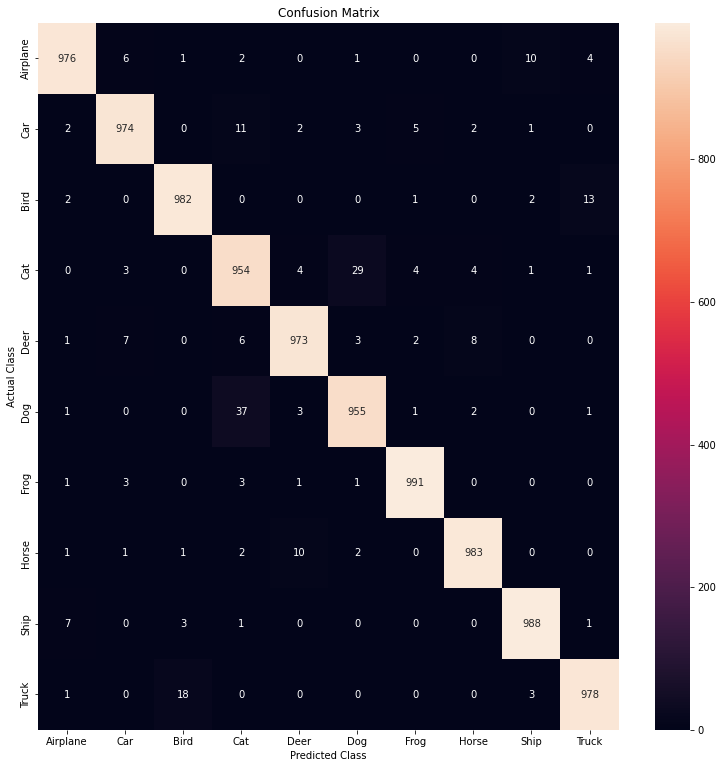

C:\Users\s_kal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s_kal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s_kal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

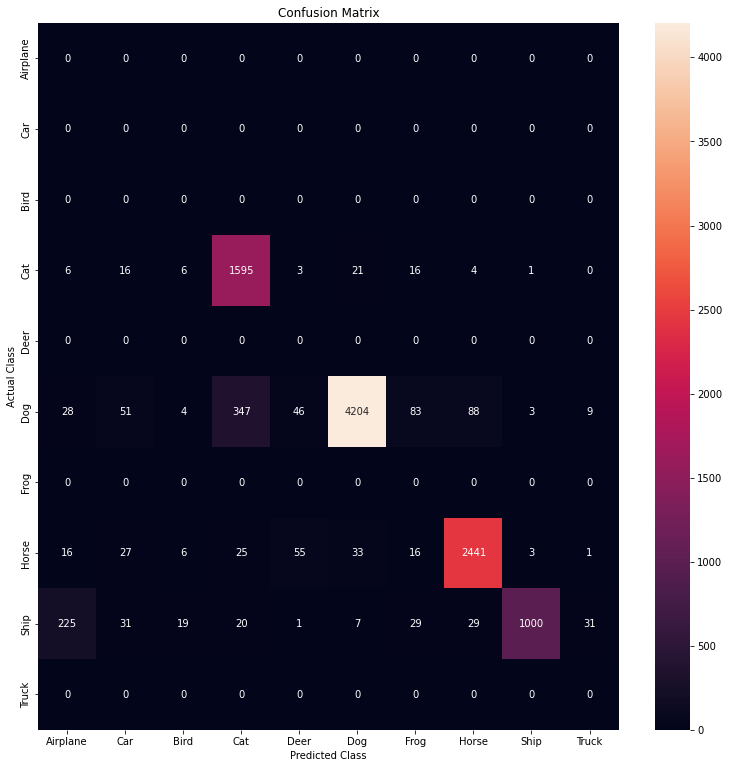

In [15]:
xtest = torch.load('C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/test_extracted_features.pt',map_location=device)
ytest = torch.load('C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/test_extracted_labels.pt',map_location=device)
xgen = torch.load('C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/gen_extracted_features.pt',map_location=device)
ygen = torch.load('C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/gen_extracted_labels.pt',map_location=device)

n_inputs = len(xtest[0])

params_file = open("C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/Evaluate Optimal Models/FFNN Results/params.json")
config = json.load(params_file)
params_file.close()

model = NeuralNet(config)
model.to(device)
model_state, optimizer_state = torch.load("C:/Users/s_kal/Desktop/9039-ML/Final Project/Code/Evaluate Optimal Models/FFNN Results/checkpoint")
model.load_state_dict(model_state)
model.to(device)

test_acc =  model_eval(xtest, ytest, model, 'test')
gen_acc = model_eval(xgen, ygen, model, 'gen')


In [16]:
train_acc

0.9758

In [17]:
gen_acc

0.8761615778494216